In [3]:
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [4]:
DATA_ROOT = Path("../data")

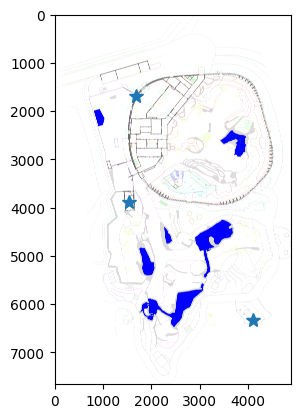

In [5]:
# Map to world constraints
@dataclass
class WorldMapConstraints:
    world2_points: np.ndarray
    map_points: np.ndarray

map_constraints= WorldMapConstraints(
    world2_points=np.array([(-73.29,55.69),(-77.21,-6.51),(-4.88,-75.34)]),
    map_points=np.array([(1682,1683),(1543,3886),(4106,6327)]))

def imread_rgb(name):
    m = cv2.imread(name)
    return cv2.cvtColor(m,cv2.COLOR_BGR2RGB)
map_file = "kkep_floorplan.png"
im_map = imread_rgb(DATA_ROOT / map_file)
plt.imshow(im_map)
plt.plot(map_constraints.map_points[:,0],map_constraints.map_points[:,1],"*",markersize=10)

In [227]:
# Homogenous coordinates utilities
def to_h(x,hvalue = 1):
    if len(x.shape) == 1:
        return np.concatenate([x, np.full((1,),hvalue)])
    else:
        count = x.shape[0]
        return np.concatenate([x, np.full((count,1),hvalue)],axis=1)

def from_h(x):
    if len(x.shape) == 1:
        return x[0:-1] / x[-1]
    else:
        return x[:, 0:-1] / x[:, [-1]]

def hmult(A,b):
    np.testing.assert_equal(len(A.shape),2)
    np.testing.assert_equal(A.shape[1],b.shape[-1]+1)
    bh = to_h(b)
    Abh =(A @ bh.T).T
    return from_h(Abh)

print("Homogenous utilities tests")
a2 = np.array([[0,0],[1,1],[2,2],[3,3]])
print(to_h(a2))
print(from_h(to_h(a2)))
A = np.eye(3)
hmult(A,np.ones((2,)))
hmult(A,np.ones((10,2)))

Homogenous utilities tests
[[0 0 1]
 [1 1 1]
 [2 2 1]
 [3 3 1]]
[[0. 0.]
 [1. 1.]
 [2. 2.]
 [3. 3.]]


array([[1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.]])

In [7]:
# Map to world calibration
from optimization_helpers import optimizeModel,IModelEvaluator


class Similarity2DEvaluator(IModelEvaluator[np.ndarray]):
    def __init__(self, points_a: np.ndarray, points_b: np.ndarray):
        super().__init__()
        count, _ = points_a.shape
        assert points_a.shape == (count, 2)
        assert points_a.shape == points_b.shape

        self.points_a = points_a
        self.points_b = points_b

    def model2params(self, model: np.ndarray) -> np.ndarray:
        return np.array([model[0, 0], model[1, 1], model[0, 2], model[1, 2]])

    def params2model(self, params: np.ndarray) -> np.ndarray:
        return np.array([[params[0], 0, params[2]], [0, params[1], params[3]],[0,0,1]])

    def getParamBounds(self) -> None:
        return None

    def evaluateModel(self, model: np.ndarray) -> float:
        points_aa = hmult(model, self.points_b)
        cost = np.sum(np.linalg.norm(points_aa-self.points_a,axis=1))
        return cost
    
evaluator = Similarity2DEvaluator(map_constraints.map_points,map_constraints.world2_points)
m0 = np.array([[1,0,0],[0,1,0]])
display(evaluator.evaluateModel(m0))
T_map_from_world2 = optimizeModel(evaluator,m0,debug=True)
display("")
print(f"Final error in pixels: {evaluator.evaluateModel(T_map_from_world2)}")
print(f"{T_map_from_world2=}")
T_world2_from_map = np.linalg.inv(T_map_from_world2)
print(f"{T_world2_from_map=}")


np.float64(14089.47791340048)

         Current function value: 1.512272
         Iterations: 96
         Function evaluations: 966
         Gradient evaluations: 191
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 1.5122718428351343
        x: [ 3.543e+01 -3.544e+01  4.279e+03  3.657e+03]
      nit: 96
      jac: [-1.424e+01  1.231e+01  1.023e+00  9.275e-01]
 hess_inv: [[ 5.132e-10 -1.240e-10  1.647e-09 -5.617e-09]
            [-1.240e-10  2.029e-10 -1.331e-09  5.206e-09]
            [ 1.647e-09 -1.331e-09  3.792e-08 -8.346e-08]
            [-5.617e-09  5.206e-09 -8.346e-08  5.318e-07]]
     nfev: 966
     njev: 191


/home/dherrera/git/zoo_vision/env/lib/python3.11/site-packages/scipy/optimize/_minimize.py:733: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


''

Final error in pixels: 1.5122718428351343
T_map_from_world2=array([[ 3.54334161e+01,  0.00000000e+00,  4.27891507e+03],
       [ 0.00000000e+00, -3.54422652e+01,  3.65677974e+03],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])
T_world2_from_map=array([[ 2.82219472e-02,  0.00000000e+00, -1.20759315e+02],
       [-0.00000000e+00, -2.82149009e-02,  1.03175678e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])


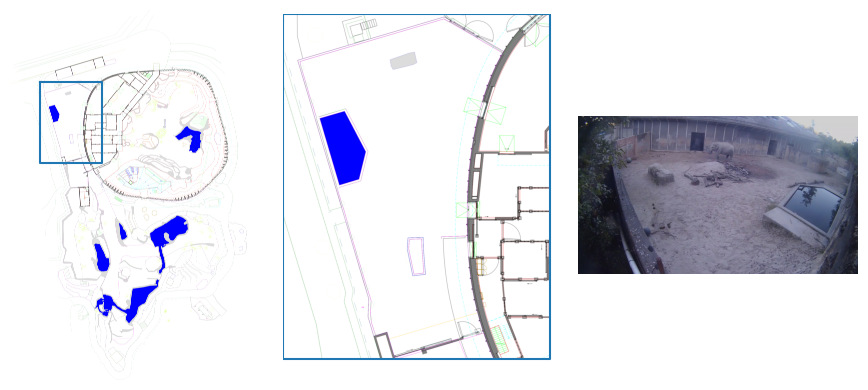

In [8]:
# Get submap for specific camera
from glob import glob
camera_name = "Kamera 01"
submap_xy = np.array([626,1500])
submap_end = np.array([1912,3164])

im_submap = im_map[submap_xy[1]:submap_end[1],submap_xy[0]:submap_end[0],:]
T_submap_from_world2 = T_map_from_world2.copy()
T_submap_from_world2[0,2] -= submap_xy[0]
T_submap_from_world2[1,2] -= submap_xy[1]
T_world2_from_submap = np.linalg.inv(T_submap_from_world2)

submap_corners_in_map = np.stack([submap_xy,submap_end])
submap_corners_in_world2 = hmult(T_world2_from_map, submap_corners_in_map)
submap_corners_in_submap = hmult(T_submap_from_world2,  submap_corners_in_world2)
def plot_rectangle_xyxy(ax,points):
    x0,y0 = points[0,0:2]
    x1,y1 = points[1,0:2]
    ax.plot([x0,x0,x1,x1,x0],[y0,y1,y1,y0,y0],"-")

image_filename = DATA_ROOT.glob(f"cameras/{camera_name}/*.jpg").__next__()
image_filename = image_filename.relative_to(DATA_ROOT)
im_camera = imread_rgb(DATA_ROOT/image_filename)
height, width,_ = im_camera.shape

fig,axs = plt.subplots(1,3,figsize=(9,4))
axs[0].imshow(im_map)
plot_rectangle_xyxy(axs[0],submap_corners_in_map)
axs[1].imshow(im_submap)
plot_rectangle_xyxy(axs[1],submap_corners_in_submap)
axs[2].imshow(im_camera)
for ax in axs:
    ax.set_axis_off()
fig.tight_layout()

In [228]:
@dataclass
class CameraConstraints:
    camera_points: np.ndarray
    world_points: np.ndarray
    floor_polygon_in_camera: np.ndarray


all_camera_constraints = {
    "Kamera 01": CameraConstraints(
        camera_points=np.array(
            [(769, 242), (860, 249), (1295, 277), (571, 471), (1709, 384), (497, 234)]
        ),
        world_points=to_h(
            np.array(
                [
                    [-75.94286309, 48.89020869],
                    [-76.50730203, 46.91516562],
                    [-77.97484329, 35.14955195],
                    [-88.5016296, 54.58961867],
                    [-85.48188124, 25.27433663],
                    [-73.2617781, 55.4924955],
                ]
            )
        ),
        floor_polygon_in_camera=np.array(
            [
                (628, 1073),
                (430, 741),
                (299, 417),
                (273, 337),
                (498, 236),
                (768, 245),
                (861, 251),
                (1298, 278),
                (1357, 284),
                (1411, 291),
                (1492, 328),
                (1564, 366),
                (1648, 401),
                (1707, 390),
                (1750, 375),
                (1838, 422),
                (1860, 456),
                (1831, 549),
                (1697, 475),
                (1516, 457),
                (1368, 611),
                (1269, 672),
                (1259, 723),
                (1621, 973),
                (1578, 1074),
            ]
        ),
    )
}
camera_constraints = all_camera_constraints.get(camera_name,None)
camera_points = None
world_points = None
floor_polygon_in_camera = None
if camera_constraints:
    # camera_points = camera_constraints.camera_points
    # world_points = camera_constraints.world_points
    floor_polygon_in_camera = camera_constraints.floor_polygon_in_camera
print(camera_constraints)

CameraConstraints(camera_points=array([[ 769,  242],
       [ 860,  249],
       [1295,  277],
       [ 571,  471],
       [1709,  384],
       [ 497,  234]]), world_points=array([[-75.94286309,  48.89020869,   1.        ],
       [-76.50730203,  46.91516562,   1.        ],
       [-77.97484329,  35.14955195,   1.        ],
       [-88.5016296 ,  54.58961867,   1.        ],
       [-85.48188124,  25.27433663,   1.        ],
       [-73.2617781 ,  55.4924955 ,   1.        ]]), floor_polygon_in_camera=array([[ 628, 1073],
       [ 430,  741],
       [ 299,  417],
       [ 273,  337],
       [ 498,  236],
       [ 768,  245],
       [ 861,  251],
       [1298,  278],
       [1357,  284],
       [1411,  291],
       [1492,  328],
       [1564,  366],
       [1648,  401],
       [1707,  390],
       [1750,  375],
       [1838,  422],
       [1860,  456],
       [1831,  549],
       [1697,  475],
       [1516,  457],
       [1368,  611],
       [1269,  672],
       [1259,  723],
       [1621

In [223]:
# Helper class to click on images
class MouseHandler:
    def __init__(self,img:np.ndarray,window_name:str,is_polygon:bool=False):
        self.img = img.copy()
        self.window_name = window_name
        self.is_polygon = is_polygon
        self.positions = []

    def start(self):
        cv2.namedWindow(self.window_name)
        cv2.setMouseCallback(self.window_name,self)
        cv2.imshow(self.window_name,self.img)

    def __call__(self,event,x,y,flags,param):
        if event == cv2.EVENT_LBUTTONDOWN:
            self.positions.append((x,y))
            count = len(self.positions)
            if self.is_polygon:
                color = [0,0,200]
            else:
                color = [0,0,0]
                color[count%3] = 200
            self.img = cv2.circle(self.img, (x,y),radius=10, color=color, thickness=5)
            if count > 1 and self.is_polygon:
                prev_x,prev_y = self.positions[count-2]
                self.img = cv2.line(self.img, (x,y),(prev_x,prev_y), color=color, thickness=3)
            cv2.imshow(self.window_name,self.img)

In [224]:
# Draw floor polygon in camera
if floor_polygon_in_camera is None:
    camera_clicker = MouseHandler(im_camera, f"camera: {camera_name}", is_polygon=True)
    cv2.startWindowThread()
    camera_clicker.start()
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    floor_polygon_in_camera = camera_clicker.positions
print("Floor polygon:")
display(floor_polygon_in_camera)

Floor polygon:


array([[ 628, 1073],
       [ 430,  741],
       [ 299,  417],
       [ 273,  337],
       [ 498,  236],
       [ 768,  245],
       [ 861,  251],
       [1298,  278],
       [1357,  284],
       [1411,  291],
       [1492,  328],
       [1564,  366],
       [1648,  401],
       [1707,  390],
       [1750,  375],
       [1838,  422],
       [1860,  456],
       [1831,  549],
       [1697,  475],
       [1516,  457],
       [1368,  611],
       [1269,  672],
       [1259,  723],
       [1621,  973],
       [1578, 1074]])

In [231]:
# Click on correspondences between submap and camera
if camera_points is None or world_points is None:
    submap_clicker=MouseHandler(im_submap, "submap")
    camera_clicker = MouseHandler(im_camera, f"camera: {camera_name}")

    cv2.startWindowThread()
    submap_clicker.start()
    camera_clicker.start()

    key = cv2.waitKey(0)
    cv2.destroyAllWindows()

    camera_points =  np.array(camera_clicker.positions)
    submap_points = np.array(submap_clicker.positions)
    world2_points = hmult(T_world2_from_submap, submap_points)
    world_points = to_h(world2_points, 0)


print("World points:")
display(world_points)
print("Camera points:")
display(camera_points)

World points:


array([[-88.55807349,  54.58961867,   0.        ],
       [-73.40288784,  55.6053551 ,   0.        ],
       [-75.94286309,  48.91842359,   0.        ],
       [-76.56374592,  46.88695072,   0.        ],
       [-78.03128718,  35.29062645,   0.        ],
       [-85.4536593 ,  25.24612173,   0.        ],
       [-95.0773433 ,  49.1723577 ,   0.        ],
       [-98.88730617,  48.24126597,   0.        ]])

Camera points:


array([[ 561,  472],
       [ 502,  237],
       [ 769,  246],
       [ 862,  249],
       [1296,  276],
       [1708,  386],
       [1253,  724],
       [1637,  962]])

In [232]:

# Find homography through OpenCV
camera_constraints = CameraConstraints( camera_points = camera_points, world_points=world_points, floor_polygon_in_camera=floor_polygon_in_camera)
print(camera_constraints)

H_world2_from_camera,inliers=cv2.findHomography(camera_constraints.camera_points, camera_constraints.world_points[:,0:2])
print(f"Inliners {inliers.sum()/len(inliers):.0%}")
print(f"H_world2_from_camera=\n{H_world2_from_camera}")
H_camera_from_world2 = np.linalg.inv(H_world2_from_camera)

H_submap_from_camera = T_submap_from_world2 @ H_world2_from_camera
H_camera_from_submap = np.linalg.inv(H_submap_from_camera)
print(f"H_submap_from_camera=\n{H_submap_from_camera}")

errors = np.mean(np.linalg.norm(submap_points - hmult(H_submap_from_camera, camera_constraints.camera_points), axis=1))
print("Mean error (submap units): ", errors)

errors = np.mean(np.linalg.norm(world2_points  - hmult(H_world2_from_camera, camera_constraints.camera_points), axis=1))
print("Mean error (world units): ", errors)

errors = np.mean(np.linalg.norm(camera_constraints.camera_points -  hmult(H_camera_from_world2, camera_constraints.world_points[:,0:2]), axis=1))
print("Mean error (camera units): ", errors)


CameraConstraints(camera_points=array([[ 561,  472],
       [ 502,  237],
       [ 769,  246],
       [ 862,  249],
       [1296,  276],
       [1708,  386],
       [1253,  724],
       [1637,  962]]), world_points=array([[-88.55807349,  54.58961867,   0.        ],
       [-73.40288784,  55.6053551 ,   0.        ],
       [-75.94286309,  48.91842359,   0.        ],
       [-76.56374592,  46.88695072,   0.        ],
       [-78.03128718,  35.29062645,   0.        ],
       [-85.4536593 ,  25.24612173,   0.        ],
       [-95.0773433 ,  49.1723577 ,   0.        ],
       [-98.88730617,  48.24126597,   0.        ]]), floor_polygon_in_camera=array([[ 628, 1073],
       [ 430,  741],
       [ 299,  417],
       [ 273,  337],
       [ 498,  236],
       [ 768,  245],
       [ 861,  251],
       [1298,  278],
       [1357,  284],
       [1411,  291],
       [1492,  328],
       [1564,  366],
       [1648,  401],
       [1707,  390],
       [1750,  375],
       [1838,  422],
       [1860,  

Poly coef: [ 1.26418445  0.34201675  0.09550114 -0.18099067 -0.54521527 -0.01915056
  0.33814048]
Errors: mean=4.991201128577212, max=20.942483976277664


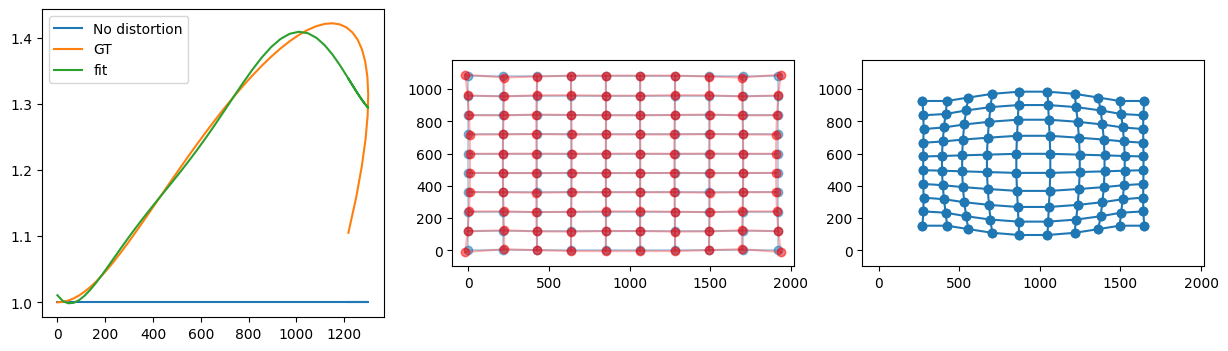

In [323]:
import scipy

def get_r2_distortion_factor(distortion_coeffs: np.ndarray, r2: np.ndarray) -> np.ndarray:
    k1,k2,k3 = distortion_coeffs
    r4 = r2*r2
    r6 = r4*r2
    factor = 1 + k1 * r2 + k2 * r4 + k3*r6
    return factor


def fit_undistort_poly_debug(
    distortion_coeffs: np.ndarray, center: np.ndarray, width: int, height: int
) :
    corners = np.array([(0, 0), (0, height), (width, 0), (width, height)])
    corners_r2 = np.sum((corners - center) ** 2, axis=1)
    
    max_rd = np.sqrt(np.max(corners_r2))
    res = scipy.optimize.minimize(lambda x: np.abs(max_rd - x*get_r2_distortion_factor(distortion_coeffs,x*x)),x0=max_rd)
    # print(res)
    # max_r = res.x[0]*100
    max_r = max_rd

    N = 50
    r = np.linspace(0, max_r, N)
    r2 = r**2
    factors = get_r2_distortion_factor(distortion_coeffs, r2)

    rd = r * factors

    poly = np.polynomial.Polynomial.fit(rd, factors, 6)
    return poly, (r, factors, rd)

def fit_undistort_poly(
    distortion_coeffs: np.ndarray, center: np.ndarray, width: int, height: int)->np.polynomial.Polynomial:
    p,_ =fit_undistort_poly_debug(distortion_coeffs, center, width,height)
    return p

def distort_points(
    distortion_coeffs:np.ndarray, center: np.ndarray, points: np.ndarray
) -> np.ndarray:
    np.testing.assert_equal(points.shape[-1], 2)
    assert center.shape in [(2,), (1, 2)]

    points_c = points - center
    r2 = np.sum(points_c**2, axis=-1)
    factor = get_r2_distortion_factor(distortion_coeffs, r2)
    factor = np.expand_dims(factor,-1)
    points_dist = center +  (points_c*factor )

    return points_dist


def undistort_points(
    undistort_poly: np.polynomial.Polynomial | None,
    center: np.ndarray,
    points_dist: np.ndarray,
) -> np.ndarray:
    if undistort_poly is None:
        return points_dist
    
    np.testing.assert_equal(points_dist.shape[-1], 2)
    assert center.shape in [(2,), (1, 2)]

    points_dist_c = points_dist - center
    rd2 = np.sum(points_dist_c**2, axis=-1)
    rd = np.sqrt(rd2)
    factor = undistort_poly(rd)
    factor = np.expand_dims(factor,-1)
    points = (points_dist_c / factor) + center

    return points


def get_image_outline_points(width, height, N):
    l2r = np.linspace(0, width - 1, N)
    b2t = np.linspace(0, height - 1, N)
    b = np.zeros_like(l2r)
    t = np.full_like(l2r, height - 1)
    l = np.zeros_like(b2t)
    r = np.full_like(b2t, width - 1)

    bl2br = np.stack([l2r, b], axis=1)
    br2tr = np.stack([r, b2t], axis=1)
    tr2tl = np.stack([np.flip(l2r), t], axis=1)
    tl2bl = np.stack([l, np.flip(b2t)], axis=1)

    all = np.concatenate([bl2br, br2tr[1:], tr2tl[1:], tl2bl[1:]])
    return all


def test_distortion_model(dist_coef, center, width, height):
    undistort_poly, (fit_r, fit_factors, fit_rd )= fit_undistort_poly_debug(dist_coef, center, width, height)
    print(f"Poly coef: {undistort_poly.coef}")

    _, axs = plt.subplots(1, 3, figsize=(15, 4))

    # Show undistortion poly
    ax = axs[0]
    ax.plot(fit_rd, get_r2_distortion_factor([0,0,0],fit_r), label="No distortion")
    ax.plot(fit_rd, fit_factors, label="GT")
    ax.plot(fit_rd, undistort_poly(fit_rd), label="fit")
    ax.legend()

    # points=get_image_outline_points(width,height,5)
    N = 10
    x = np.linspace(0, width - 1, N)
    y = np.linspace(0, height - 1, N)
    xv, yv = np.meshgrid(x, y)
    grid_shape = xv.shape

    points = np.stack([xv.reshape(-1), yv.reshape(-1)], axis=1)
    points_undist = undistort_points(undistort_poly, center, points)
    points_exp = distort_points(dist_coef, center, points_undist)

    errors = np.linalg.norm(points-points_exp, axis=1)
    print(f"Errors: mean={np.mean(errors)}, max={np.max(errors)}")

    xv_undist = points_undist[:, 0].reshape(grid_shape)
    yv_undist = points_undist[:, 1].reshape(grid_shape)

    xv_exp = points_exp[:, 0].reshape(grid_shape)
    yv_exp = points_exp[:, 1].reshape(grid_shape)

    def plot_meshgrid(ax, xv, yv, fmt="o-", color="C0", *args, **kwargs):
        # Rows
        for i in range(xv.shape[0]):
            ax.plot(xv[i, :], yv[i, :], fmt, color=color, *args, **kwargs)
        # Cols
        for i in range(xv.shape[1]):
            ax.plot(xv[:, i], yv[:, i], fmt, color=color, *args, **kwargs)

    ax = axs[1]
    plot_meshgrid(ax, xv, yv,alpha=0.3)
    plot_meshgrid(ax, xv_exp, yv_exp, color="red",alpha=0.3)
    ax.set_xlim([-100,width+100])
    ax.set_ylim([-100,height+100])
    ax.set_aspect(1)
    ax = axs[2]
    plot_meshgrid(ax, xv_undist, yv_undist)
    ax.set_xlim([-100,width+100])
    ax.set_ylim([-100,height+100])
    ax.set_aspect(1)


test_k = [0.0000013,-0.000000000001,0]
# test_k = [0.000003,0,0]
# test_k = [-0.0000003,0,0]
# test_k = [0,0,0]
center = np.array([width / 2, height / 2])
test_distortion_model(test_k, center, width, height)

Error (submap units): mean=46.88177923570789, max=84.81000147377938, sum=375.0542338856631
Error (world units): mean=1.3229351716026272, max=2.3930470455373443, sum=10.583481372821018
Error (camera units): mean=32.5787745084242, max=58.28007796110091, sum=260.6301960673936


array([<Axes: >, <Axes: >], dtype=object)

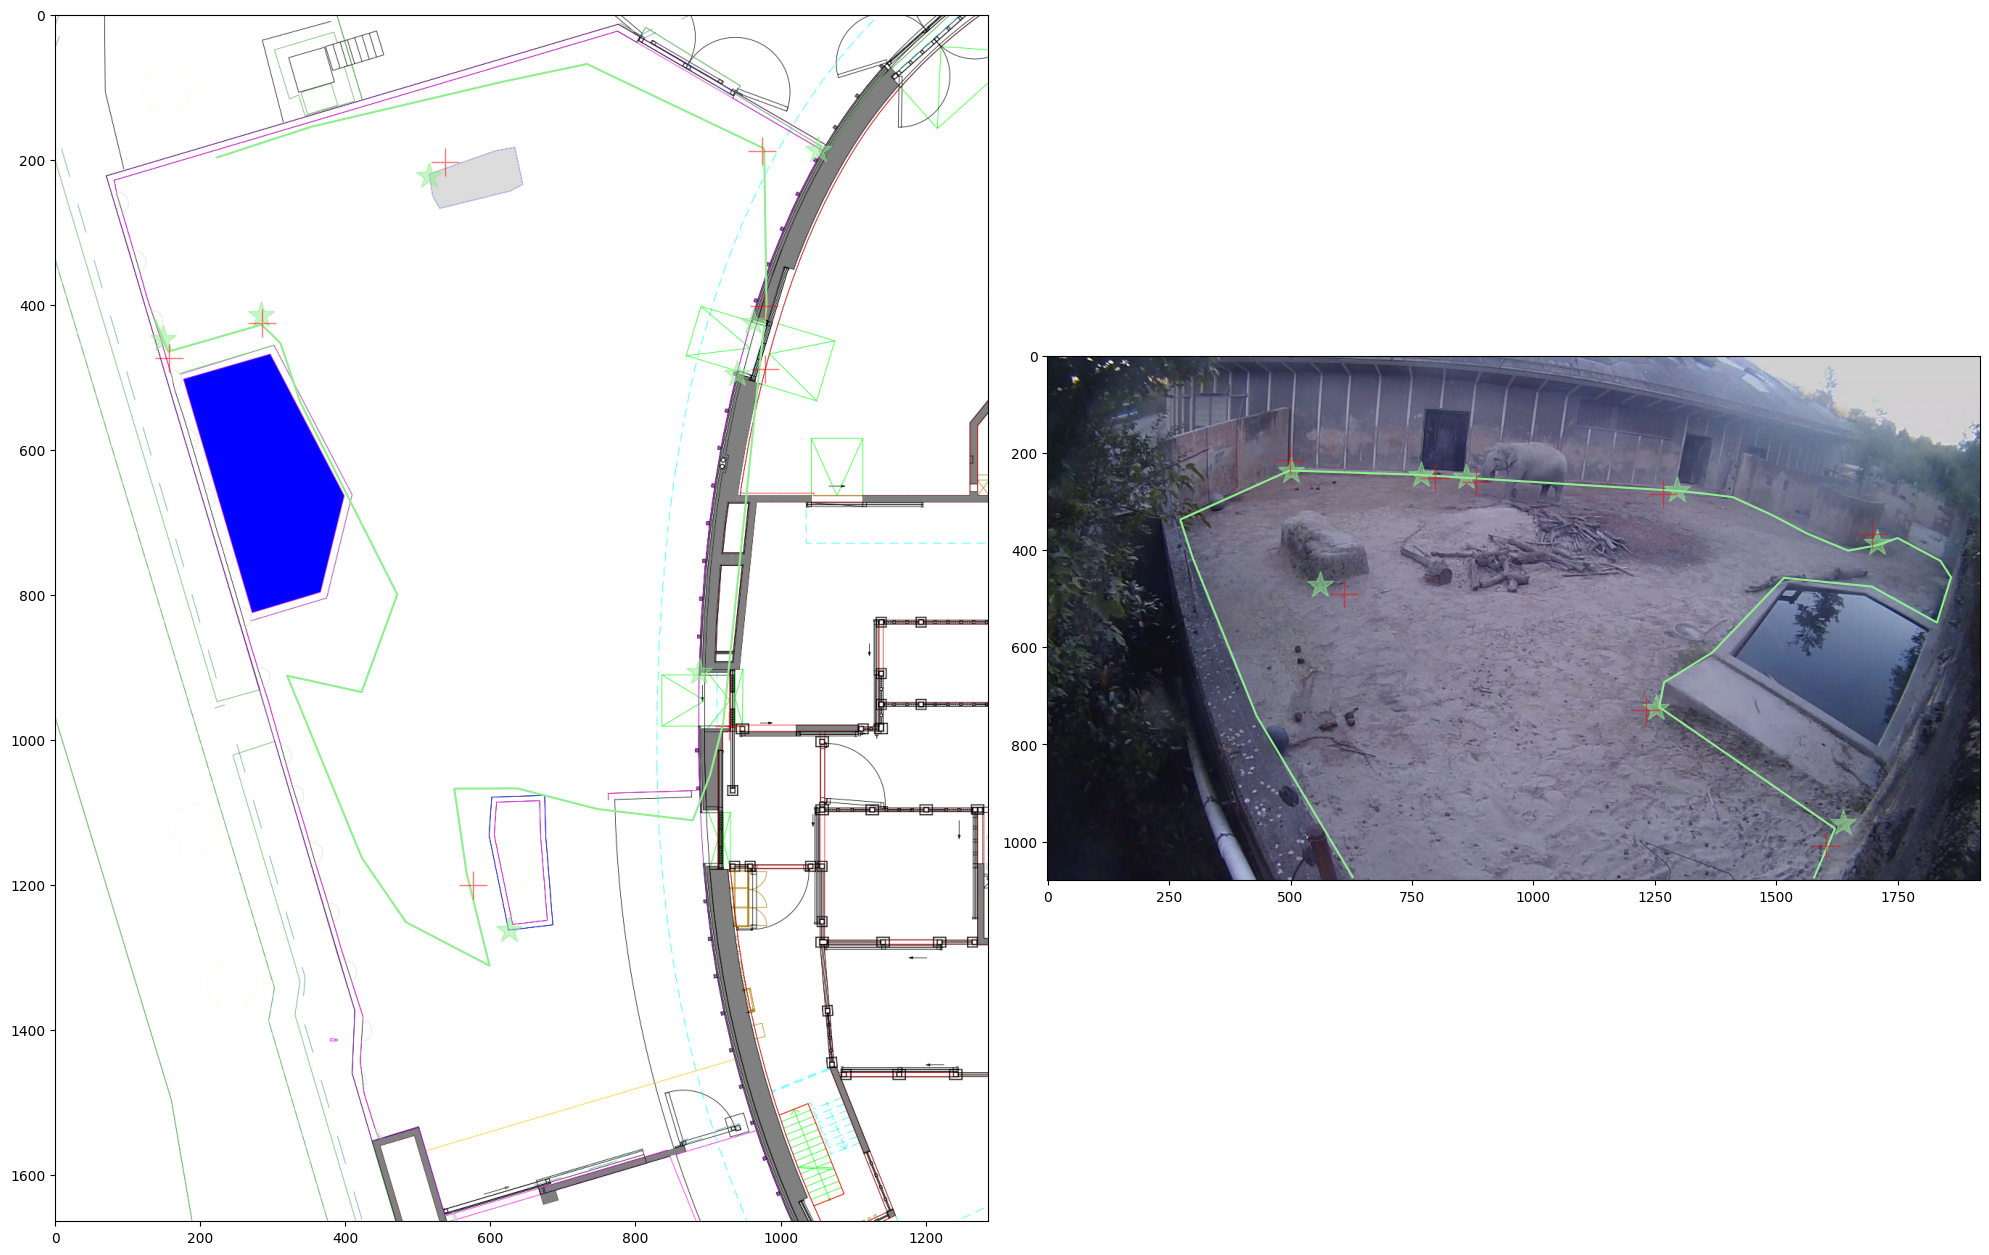

In [364]:
def plot_projections(H_camera_from_world2:np.ndarray, dist_coef:np.ndarray|None = None, center:np.ndarray| None=None):
    H_world2_from_camera = np.linalg.inv(H_camera_from_world2)
    H_submap_from_camera = T_submap_from_world2 @H_world2_from_camera

    undistort_poly = fit_undistort_poly(dist_coef,center, width,height) if dist_coef is not None else None

    def undistort(p):
        return undistort_points(undistort_poly,center,p) if dist_coef is not None else p
    def distort(p):
        return distort_points(dist_coef,center,p) if dist_coef is not None else p
        
    floor_polygon_in_camera = camera_constraints.floor_polygon_in_camera
    camera_points =  camera_constraints.camera_points
    world2_points =  camera_constraints.world_points[:,0:2]

    floor_polygon_in_submap = hmult(H_submap_from_camera, undistort(floor_polygon_in_camera))
    submap_points = hmult(T_submap_from_world2, world2_points)
    camera_points_exp = distort(hmult(H_camera_from_world2, world2_points))
    submap_points_exp = hmult(H_submap_from_camera, undistort(camera_points))

    errors = np.linalg.norm(submap_points - hmult(H_submap_from_camera, camera_constraints.camera_points), axis=1)
    print(f"Error (submap units): mean={np.mean(errors)}, max={np.max(errors)}, sum={np.sum(errors)}")

    errors = np.linalg.norm(world2_points  - hmult(H_world2_from_camera, camera_constraints.camera_points), axis=1)
    print(f"Error (world units): mean={np.mean(errors)}, max={np.max(errors)}, sum={np.sum(errors)}")

    errors = np.linalg.norm(camera_constraints.camera_points -  hmult(H_camera_from_world2, camera_constraints.world_points[:,0:2]), axis=1)
    print(f"Error (camera units): mean={np.mean(errors)}, max={np.max(errors)}, sum={np.sum(errors)}")

    fig,axs = plt.subplots(1,2,figsize=(20,15))
    axs[0].imshow(im_submap)
    axs[1].imshow(im_camera)
    ax = axs[0]
    ax.plot(floor_polygon_in_submap[:,0],floor_polygon_in_submap[:,1],"-",color="lightgreen")
    ax = axs[1]
    ax.plot(floor_polygon_in_camera[:,0],floor_polygon_in_camera[:,1],"-",color="lightgreen")
    for i in range(camera_constraints.camera_points.shape[0]):
        ax = axs[0]
        ax.plot(submap_points[i,0],submap_points[i,1],"*",markersize=20, color="lightgreen",alpha=0.5)
        ax.plot(submap_points_exp[i,0],submap_points_exp[i,1],"+",markersize=20, color= "red",alpha=0.5)

        ax = axs[1]
        ax.plot(camera_points[i,0],camera_points[i,1],"*",markersize=20, color="lightgreen",alpha=0.5)
        ax.plot(camera_points_exp[i,0],camera_points_exp[i,1],"+",markersize=20, color="red",alpha=0.5)

    fig.tight_layout()
    return axs
plot_projections(H_camera_from_world2)

Cost at start: 260.6301960673936
         Current function value: 144.539265
         Iterations: 70
         Function evaluations: 3012
         Gradient evaluations: 200
Final cost: 144.53926526087352
hd_model=HDistModel(dist_coef=array([0., 0., 0.]), center=array([960., 540.]), H_camera_from_world2=array([[ 6.44363558e+00, -3.48267434e+01,  2.63476315e+03],
       [-1.83879298e+00, -4.80184559e+00,  2.36388874e+02],
       [ 1.69347741e-02, -1.23506826e-02,  2.46439027e+00]]))
Poly coef: [ 1.00000000e+00  3.95733942e-16 -1.47679080e-15 -2.21183573e-15
  4.72516577e-15  2.53500543e-15 -5.03147990e-15]
Errors: mean=5.332391764724349e-13, max=1.8331451766013172e-12
Error (submap units): mean=41.53548499182352, max=156.47506370340685, sum=332.2838799345882
Error (world units): mean=1.1721195056181544, max=4.415447396997356, sum=9.376956044945235
Error (camera units): mean=18.067408157609197, max=90.85100542194701, sum=144.53926526087358


/home/dherrera/git/zoo_vision/env/lib/python3.11/site-packages/scipy/optimize/_minimize.py:733: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


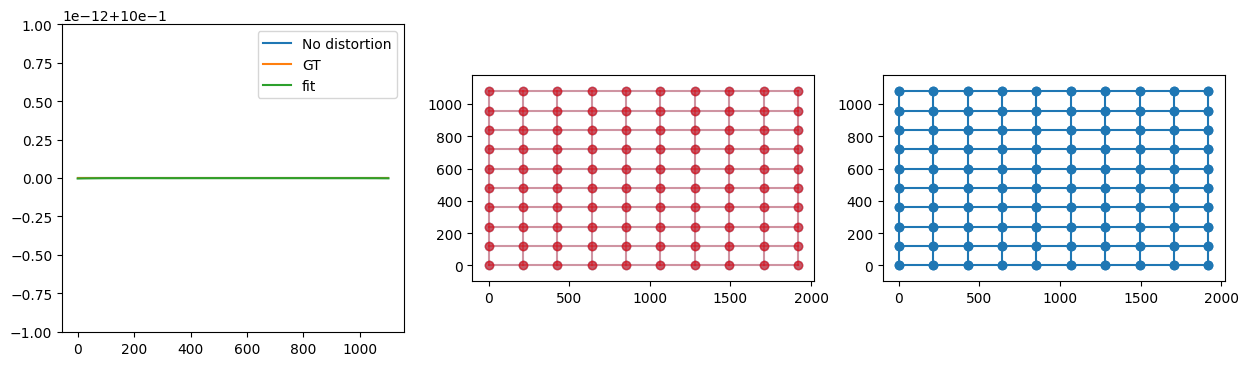

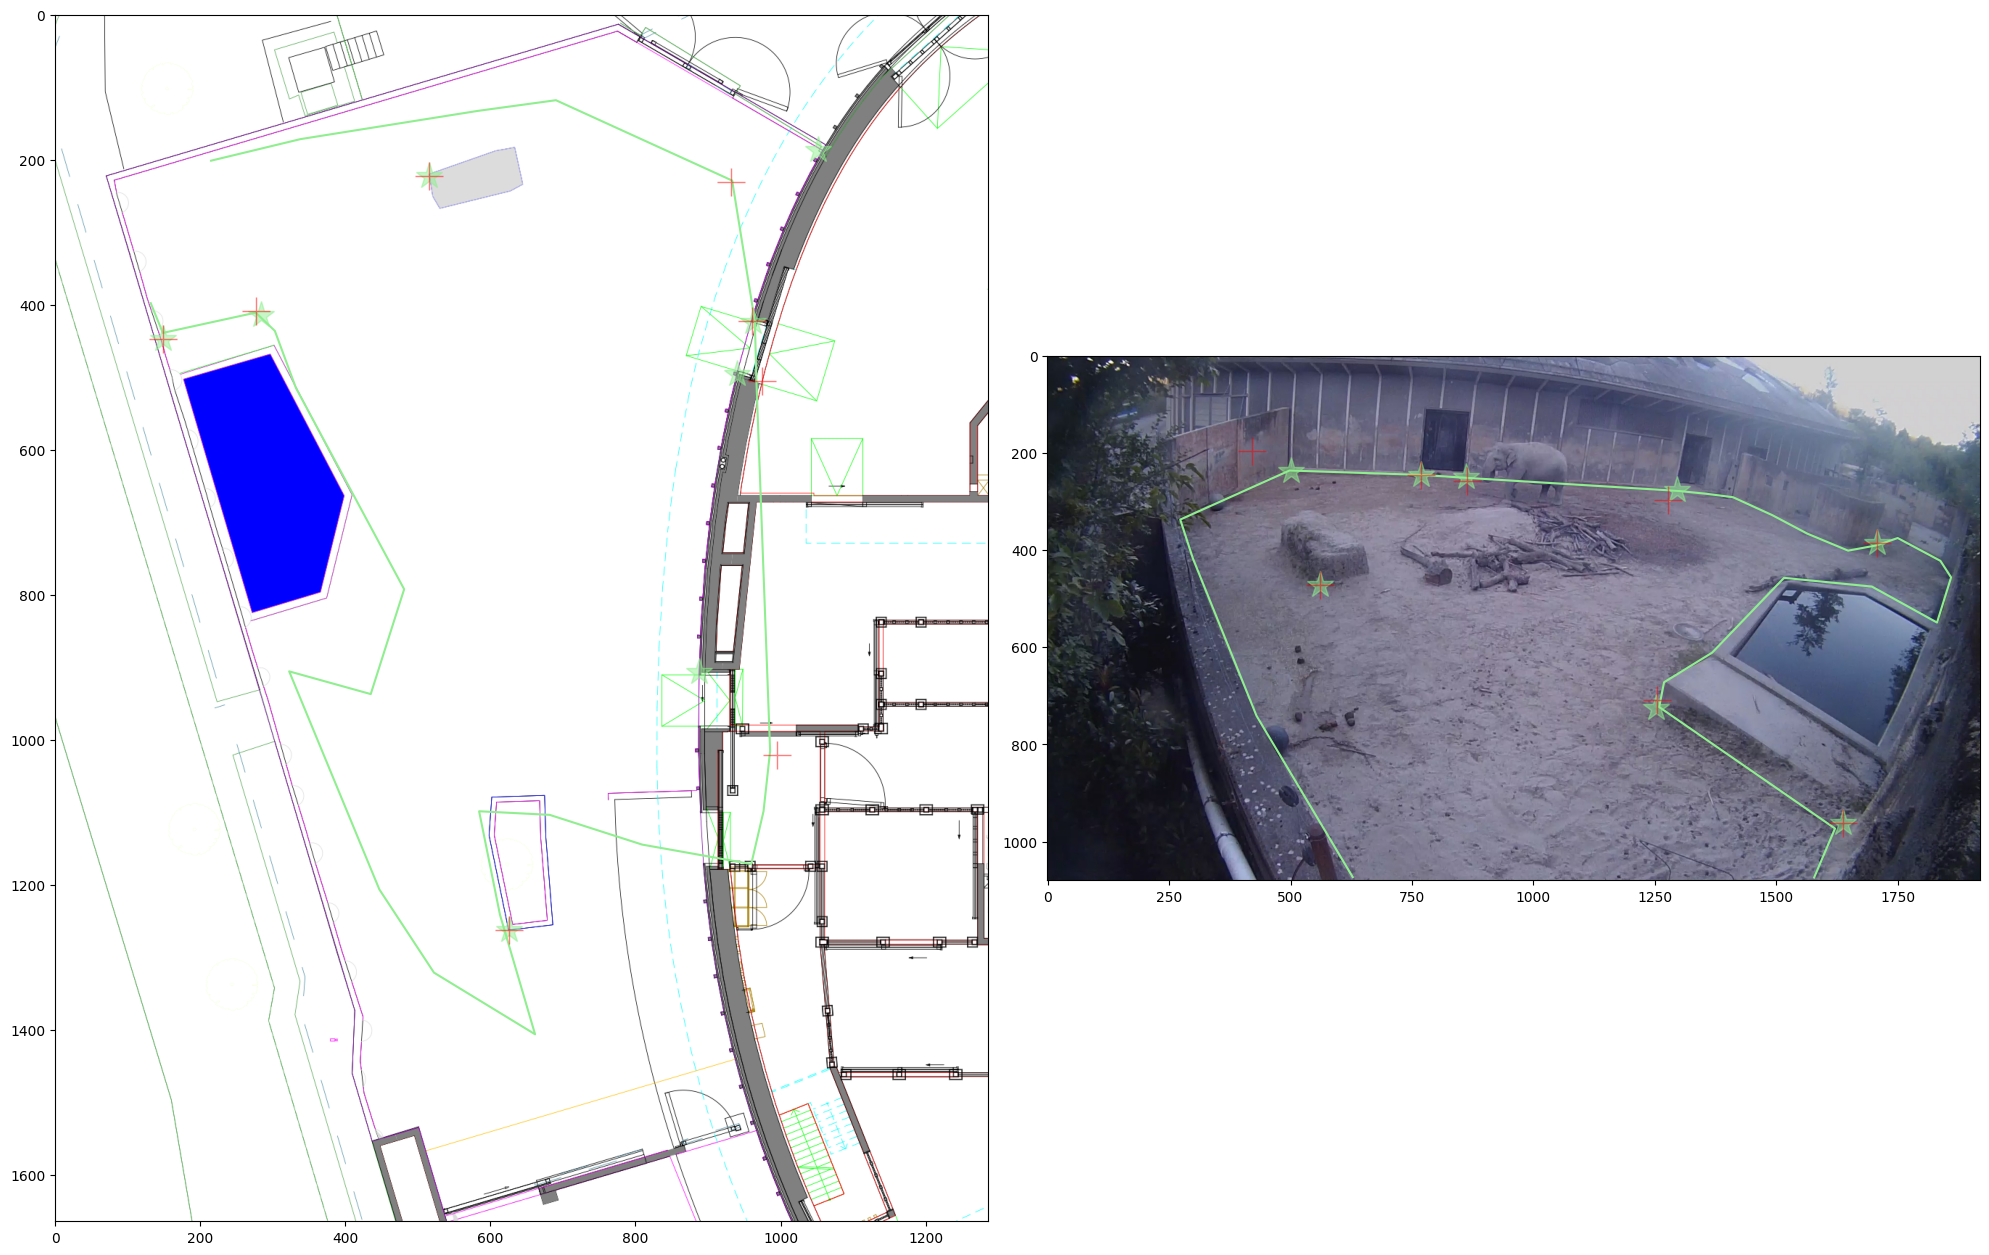

In [324]:
# Optimize distortion+homography
import scipy.optimize
from optimization_helpers import optimizeModel,IModelEvaluator
from dataclasses import dataclass
import scipy

@dataclass 
class HDistModel:
    dist_coef: np.ndarray
    center:np.ndarray
    H_camera_from_world2: np.ndarray

class HDistEvaluator(IModelEvaluator[HDistModel]):
    def __init__(self, model0: HDistModel):
        super().__init__()
        self.model0 = model0

    def model2params(self, model: HDistModel) -> np.ndarray:
        Hl = model.H_camera_from_world2.reshape(-1)
        params_list = [*model.dist_coef*1e6,*model.center, *Hl[:]]
        # params_list = [*model.dist_coef*1e6,*model.center]
        return np.array(params_list)

    def params2model(self, params: np.ndarray) -> HDistModel:
        dist_coef = params[0:3]/1e6
        dist_coef[0] = 0
        dist_coef[1] = 0
        dist_coef[2] = 0
        center = params[3:5]
        H = params[5:].reshape((3,3))
        # H = self.model0.H_camera_from_world2
        model = HDistModel(
                    dist_coef=dist_coef,
                    center=center,H_camera_from_world2=H,

                    )
        return model

    def getParamBounds(self) -> scipy.optimize.Bounds|None:
        return None

    def evaluateModel(self, model: HDistModel) -> float:
        world2_points = camera_constraints.world_points[:,0:2]
        camera_points = camera_constraints.camera_points
        camera_points_undist_exp= hmult(model.H_camera_from_world2, world2_points)
        camera_points_exp = distort_points(model.dist_coef,center,camera_points_undist_exp)
        errors = np.linalg.norm(camera_points - camera_points_exp,axis=1)
        # print(f"d={model.dist_coef}, a={np.sum(errors)}")

        # camera_points_exp2 = distort_points([model.dist_coef[0]-0.3,0,0],center,camera_points_undist_exp)
        # errors2 = np.linalg.norm(camera_points - camera_points_exp2,axis=1)
        # print("a=",np.sum(errors),"b=",np.sum(errors2))

        return np.sum(errors) 

hd_model0 = HDistModel(dist_coef=np.array([0.0,0,0]),center=np.array([width/2,height/2]),H_camera_from_world2=H_camera_from_world2)
evaluator = HDistEvaluator(model0=hd_model0)
print(f"Cost at start: {evaluator.evaluateModel(hd_model0)}")

# hd_model= optimizeModel(evaluator,hd_model0)
params0 = evaluator.model2params(hd_model0)
res = scipy.optimize.minimize(
    evaluator, params0, bounds=evaluator.getParamBounds(), options={"disp": True}
)
hd_model = evaluator.params2model(res.x)

print(f"Final cost: {evaluator.evaluateModel(hd_model)}")
print(f"{hd_model=}")

# H_exp = h_model0.make_H()
# errors = np.mean(np.linalg.norm(camera_constraints.camera_points -  hmult(H_exp, camera_constraints.world_points[:,0:2]), axis=1))
# print("Mean H direct error (camera units): ", errors)

# H_exp = h_model.make_H()
# errors = np.mean(np.linalg.norm(camera_constraints.camera_points -  hmult(H_exp, camera_constraints.world_points[:,0:2]), axis=1))
# print("Mean H direct error (camera units): ", errors)

# print("R norm errors: ", evaluator.get_norm_errors(h_model))

test_distortion_model(hd_model.dist_coef,hd_model.center,width,height)
plot_projections(hd_model.H_camera_from_world2, hd_model.dist_coef, hd_model.center)

[1030.71067812  469.28932188]
[ 1. -1. -1.]


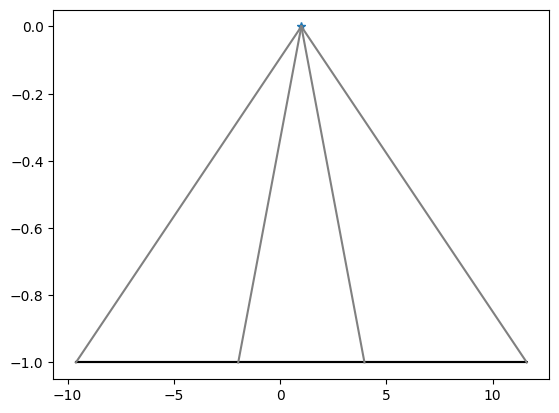

In [325]:
@dataclass
class KRt:
    width: int
    height: int
    dist_coef: np.ndarray
    undistort_poly: np.polynomial.Polynomial
    K: np.ndarray
    R_world_from_camera: np.ndarray
    t_in_world: np.ndarray

    def __repr__(self):
        return f"dist_coef={self.dist_coef}\nK=\n{self.K}\nR_world_from_camera=\n{self.R_world_from_camera}\nt_in_world={self.t_in_world.T}"

    def get_center_in_world(self) -> np.ndarray:
        return self.t_in_world

    def project_points(self, points_in_world: np.ndarray) -> np.ndarray:
        R_camera_from_world=self.R_world_from_camera.T
        points_in_camera = (R_camera_from_world @ (points_in_world - self.t_in_world).T).T
        points_in_camera_norm = (self.K @ points_in_camera.T).T
        points_in_image_undist = from_h(points_in_camera_norm)
        points_in_image = distort_points(
            self.dist_coef, self.K[0:2, 2], points_in_image_undist
        )
        return points_in_image

    def unproject_points(self, points_in_image: np.ndarray, depth=1) -> np.ndarray:
        invK = np.linalg.inv(self.K)

        points_in_image_undist = undistort_points(
            self.undistort_poly, self.K[0:2, 2], points_in_image
        )
        camera_points_norm = (invK @ to_h(points_in_image_undist).T).T
        world_points = (
            self.R_world_from_camera @ camera_points_norm.T
        ).T * depth + self.t_in_world
        return world_points


def plot_camera(ax, model: KRt, scale=1, T_image_from_world: np.ndarray | None=None):
    center = model.get_center_in_world().squeeze()
    h, w = model.height, model.width
    p = np.array([[0, 0], [0, h], [w, h], [w, 0]])
    xyz = model.unproject_points(p, scale)

    # Drop z
    xy = xyz[:,0:2]

    if T_image_from_world is not None:
        xy = hmult(T_image_from_world, xy)

    x = xy[:,0]
    y = xy[:,1]
    ax.plot([center[0]], [center[1]], "*")
    ax.plot(
        [x[0], x[1], x[2], x[3], x[0]],
        [y[0], y[1], y[2], y[3], y[0]],
        "-",
        color="black",
    )
    for i in range(4):
        ax.plot([center[0], x[i]], [center[1], y[i]], "-", color="gray")


R = scipy.spatial.transform.Rotation.from_euler(
    seq="xyz", angles=[np.pi / 2, np.pi / 4, 0]
).as_matrix()
# print(R)
center = np.array((width/2,height/2))
dummy_dist = np.array([0,0,0])
dummy_model = KRt(
    width=width,
    height=height,
    dist_coef=dummy_dist,
    undistort_poly=fit_undistort_poly(dummy_dist,center,width,height),
    K=np.array([[100,0,width/2],[0,100,height/2],[0,0,1]]),
    R_world_from_camera=R,
    t_in_world=np.array([1, 0, 0]),
)
_, ax = plt.subplots(1, 1)
p = np.array([1,-1,-1])
x=dummy_model.project_points(p)
print(x)
pp = dummy_model.unproject_points(x)
print(pp)
plot_camera(ax, dummy_model, scale=1)

In [326]:
def make_H(K: np.ndarray, R: np.ndarray, t: np.ndarray):
    Rt = np.concatenate([R[:,[0,1]],t.reshape((3,1))],axis=1)
    Hp = K @ Rt
    return Hp

def make_H_camera_from_world2(camera: KRt):
    R_camera_from_world = camera.R_world_from_camera.T
    t_in_camera = -R_camera_from_world @ camera.t_in_world
    return make_H(camera.K, R_camera_from_world, t_in_camera)

make_H_camera_from_world2(dummy_model)

array([[ 7.07106781e+01, -9.60000000e+02, -7.07106781e+01],
       [ 7.07106781e+01, -5.40000000e+02, -7.07106781e+01],
       [ 1.11022302e-16, -1.00000000e+00, -1.11022302e-16]])

First R approximation
R=
[[-0.51461129 -1.20450078  0.0480501 ]
 [-0.57595425  0.09792879 -0.23565795]
 [ 0.1491684  -0.10878986 -0.74413261]]
Det=0.6115768223014884
Error (submap units): mean=41.53548499182377, max=156.47506370340363, sum=332.2838799345902
Error (world units): mean=1.1721195056181657, max=4.4154473969972665, sum=9.376956044945326
Error (camera units): mean=18.06740815760905, max=90.85100542194616, sum=144.5392652608724


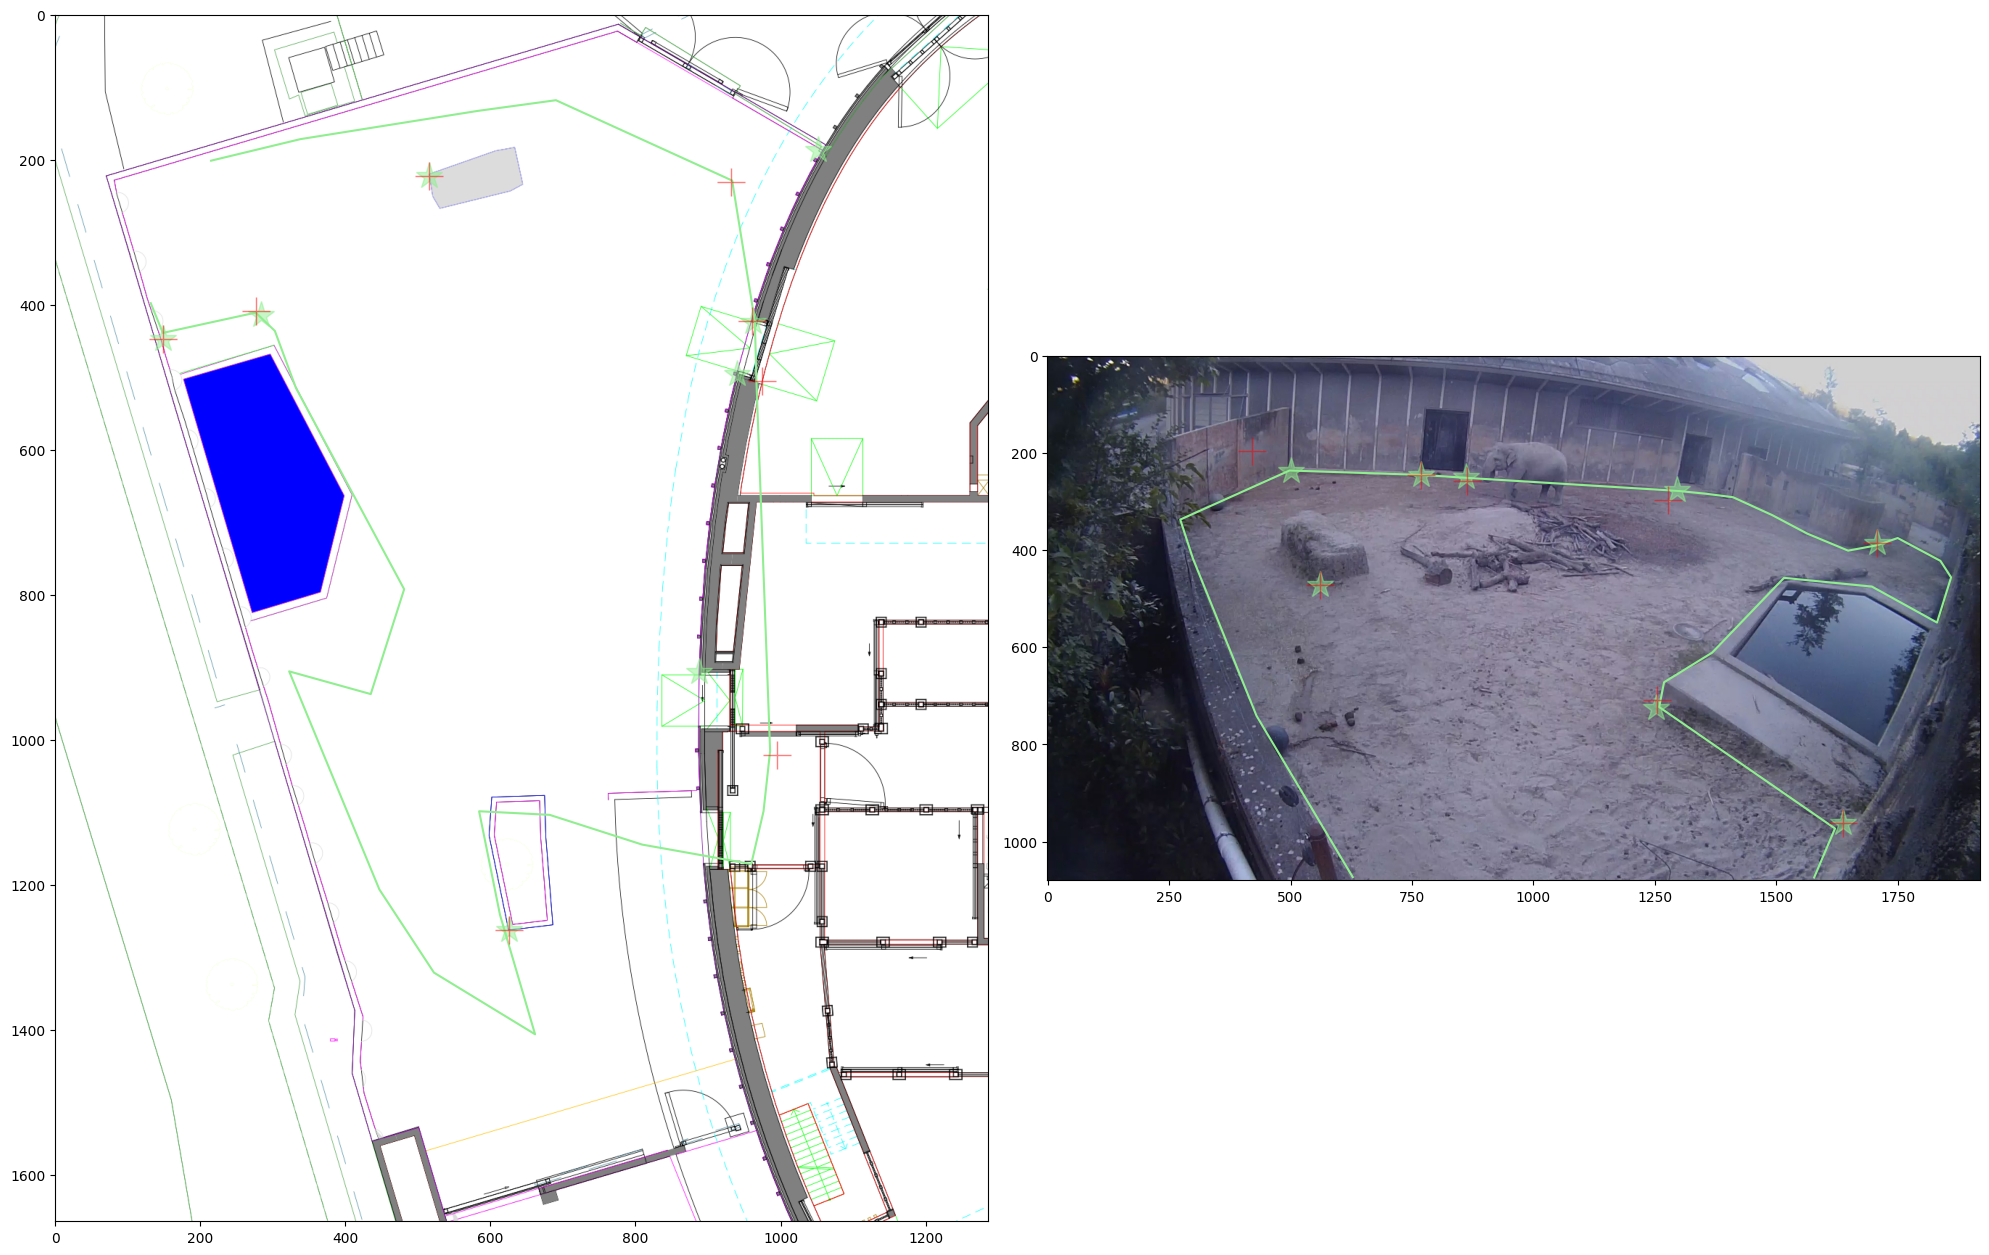

In [327]:
# Decompose homography into K*[R|t]
# Construct a default K matrix
fov = 170 * np.pi / 180 # Assume our cameras have a wide fov
fx = width / np.tan(fov/2)
# print(f"H=\n{H_camera_from_world2}")

K0 = np.array([[fx,0,hd_model.center[0]],[0,fx,hd_model.center[1]],[0,0,1]])
invK0 = np.linalg.inv(K0)
# print(f"{K0=}")

Rt = invK0 @ hd_model.H_camera_from_world2
# print(f"Rt=\n{Rt}")

factor = np.mean([np.linalg.norm(Rt[:,0]),np.linalg.norm(Rt[:,1])])
Rt /= factor
r1 = Rt[:,0]
r2 = Rt[:,1]
r3 = np.cross(r1,r2)
R = np.stack([r1,r2,r3]).T
# print(r1)
t = Rt[:,2]
print("First R approximation")
print(f"R=\n{R}")
print(f"Det={np.linalg.det(R)}")

# W,U,Vt=cv2.SVDecomp(R)
# R = U@Vt
# print("Second R approximation")
# print(R)
# print(f"Det={np.linalg.det(R)}")

H_exp = make_H(K0,R,t)
plot_projections(H_exp,hd_model.dist_coef,hd_model.center)
# errors = np.mean(np.linalg.norm(camera_constraints.camera_points -  hmult(H_exp, camera_constraints.world_points[:,0:2]), axis=1))
# print("Mean H direct error (camera units): ", errors)

# camera_in_world = KRt(width=width,height=height,dist_coef=hd_model.dist_coef,K=K0,R_world_from_camera=R.T,t_in_world=-R.T@t)
# print(camera_in_world)
# # T_camera_from_world = np.concatenate([R,t[:,None]],axis=1)
# # T_camera_from_world = np.concatenate([T_camera_from_world, [[0,0,0,1]]],axis=0)
# # T_world_from_camera = np.linalg.inv(T_camera_from_world)
# # print(f"T_camera_from_world=\n{T_camera_from_world}")
# # print(f"T_world_from_camera=\n{T_world_from_camera}")

# def homography_error(Ha,Hb):
#     sHa = np.linalg.norm(Ha.reshape((-1)))
#     sHb = np.linalg.norm(Hb.reshape((-1)))
#     Ha = Ha *sHb/sHa
#     cost = np.linalg.norm((Hb - Ha).reshape(-1))
#     return cost


Cost at start: 1118.4825178902752
Final cost: 167.6000396687315
h_model=RtModel(dist_coef=array([0., 0., 0.]), K=array([[163.48525869,   0.        , 999.069173  ],
       [  0.        , 133.04707359, 955.95331661],
       [  0.        ,   0.        ,   1.        ]]), R=array([[-0.39364146, -0.91878739],
       [-0.91238683,  0.38565912],
       [ 0.11663663, -0.08396939]]), t=array([  10.19969998, -108.77049459,   16.81493408]))
R norm errors:  [5.03587636e-04 2.29599595e-05 8.60264253e-06]
Error (submap units): mean=45.52652273976318, max=127.44035796213424, sum=364.21218191810544
Error (world units): mean=1.2847022443470766, max=3.5959355004569447, sum=10.277617954776613
Error (camera units): mean=20.88311117884698, max=61.99013934073033, sum=167.06488943077585


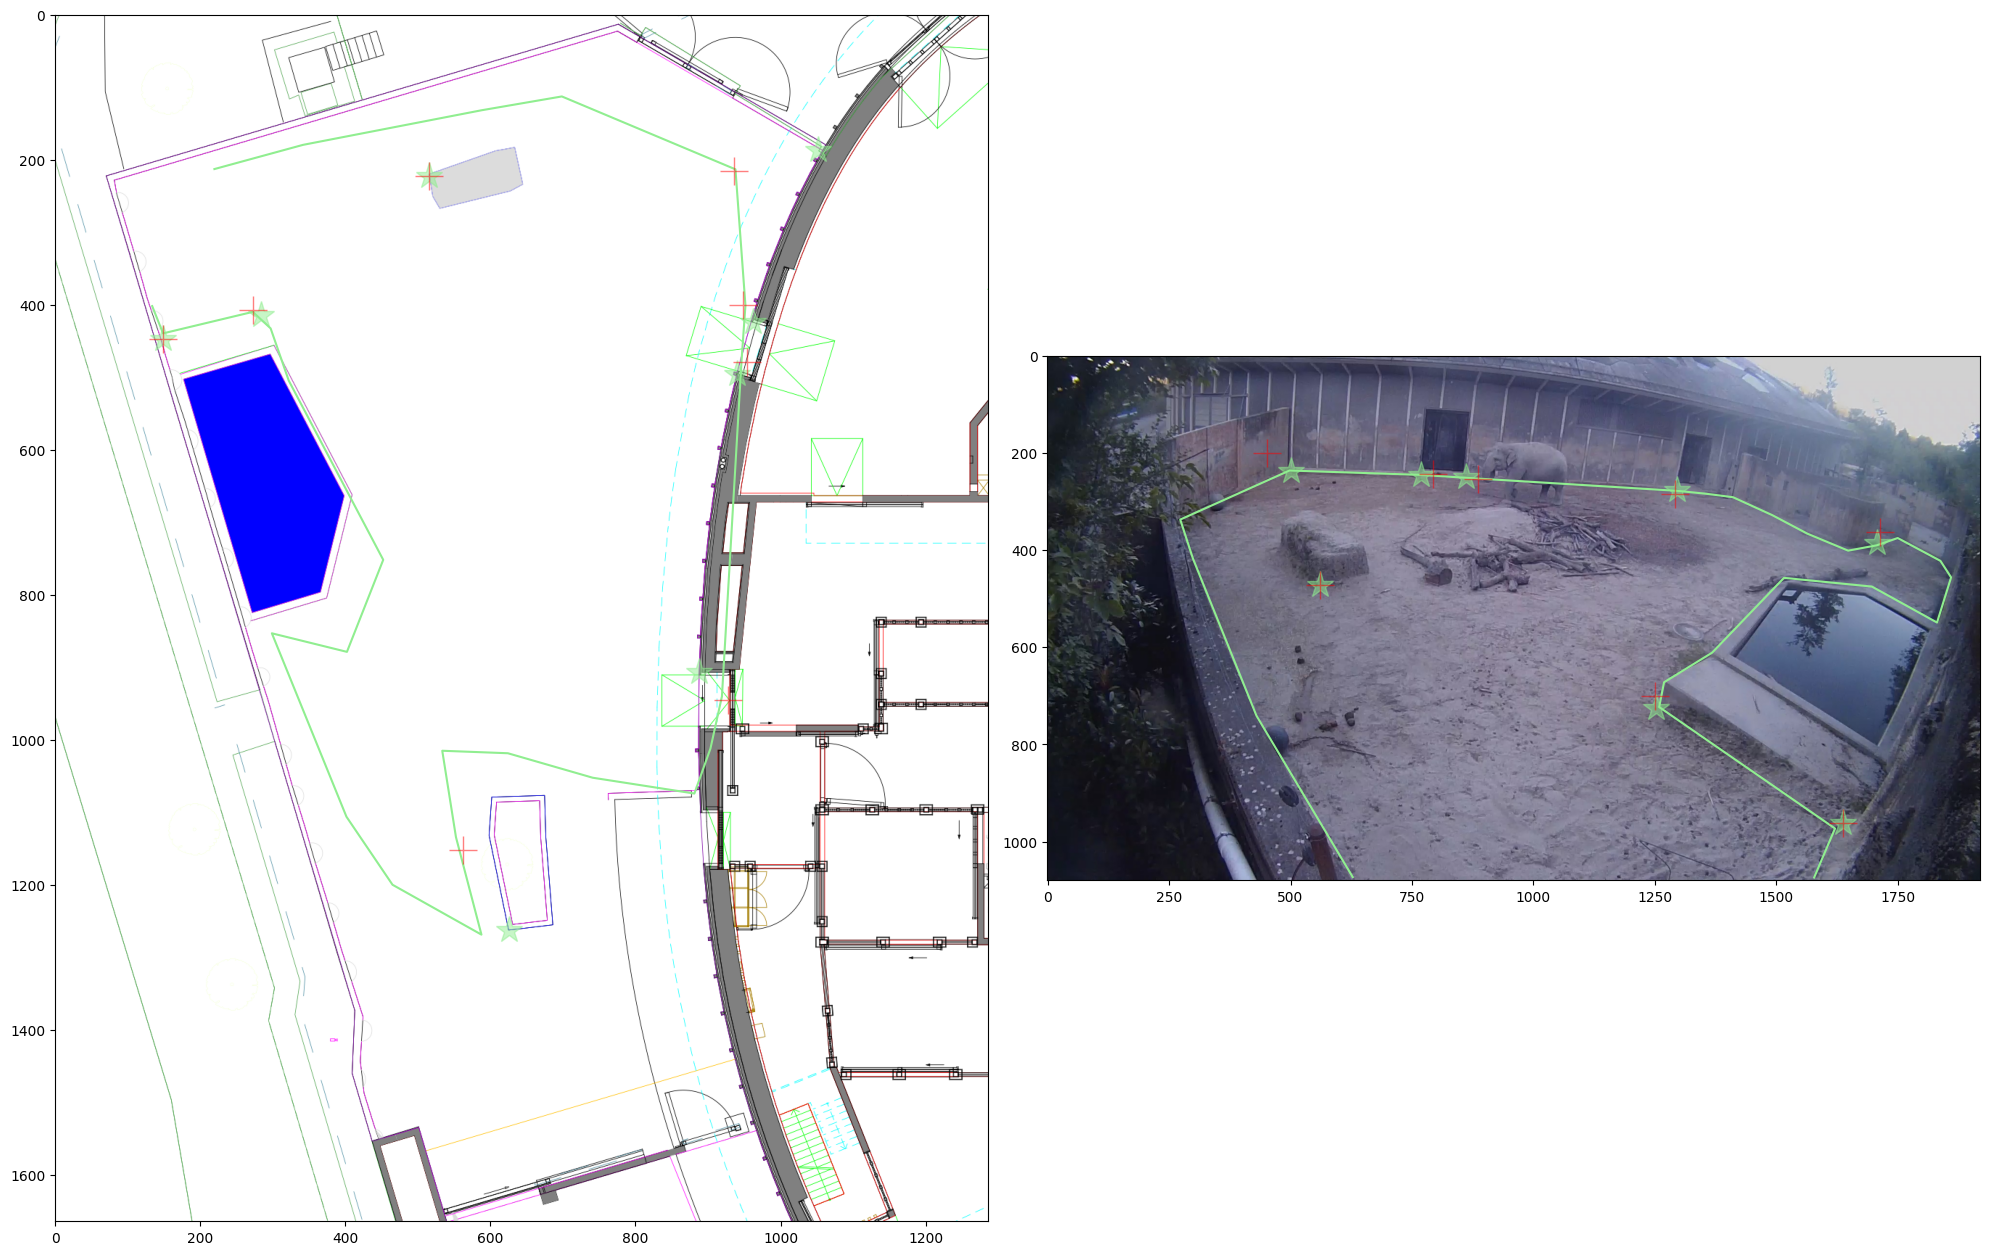

In [339]:
import scipy.optimize
from optimization_helpers import optimizeModel, IModelEvaluator
from dataclasses import dataclass
import scipy


@dataclass
class RtModel:
    dist_coef: np.ndarray
    K: np.ndarray
    R: np.ndarray
    t: np.ndarray

    def make_H(self):
        return make_H(self.K, self.R, self.t)


class RtEvaluator(IModelEvaluator[RtModel]):
    def __init__(self, model0: RtModel):
        super().__init__()
        self.model0 = model0

    def model2params(self, model: RtModel) -> np.ndarray:
        k1, k2, k3 = model.dist_coef*1e6
        fx = model.K[0, 0]
        alpha = model.K[1, 1] / fx
        cx = model.K[0, 2]
        cy = model.K[1, 2]
        r1x, r1y, r1z = model.R[:, 0]
        r2x, r2y, r2z = model.R[:, 1]
        tx, ty, tz = model.t.reshape((3,))
        params_list = [
            # k1,
            # k2,
            # k3,
            fx,
            alpha,
            cx,
            cy,
            r1x,
            r1y,
            r1z,
            r2x,
            r2y,
            r2z,
            tx,
            ty,
            tz,
        ]
        return np.array(params_list)

    def params2model(self, params: np.ndarray) -> RtModel:
        # k1,k2,k3,fx, alpha, cx, cy, r1x, r1y, r1z, r2x, r2y, r2z, tx, ty, tz = params
        fx, alpha, cx, cy, r1x, r1y, r1z, r2x, r2y, r2z, tx, ty, tz = params
        # dist_coef = np.array([k1, k2, k3])/1e6
        dist_coef = self.model0.dist_coef
        K = np.array([[fx, 0, cx], [0, fx * alpha, cy], [0, 0, 1]])
        R = np.array(
            [
                [r1x, r1y, r1z],
                [
                    r2x,
                    r2y,
                    r2z,
                ],
            ]
        ).T
        t = np.array([tx, ty, tz])
        model = RtModel(dist_coef=dist_coef, K=K, R=R, t=t)
        return model

    def getParamBounds(self) -> scipy.optimize.Bounds | None:
        return None

    def get_norm_errors(self, model: RtModel) -> np.ndarray:
        r1 = model.R[:, 0]
        r2 = model.R[:, 1]
        error_norm1 = np.abs((1 - np.linalg.norm(r1)))
        error_norm2 = np.abs((1 - np.linalg.norm(r2)))
        error_prod = np.abs(np.dot(r1, r2))
        return np.array([error_norm1, error_norm2, error_prod])

    def evaluateModel(self, model: RtModel) -> float:
        H_exp = model.make_H()

        world2_points = camera_constraints.world_points[:,0:2]
        camera_points = camera_constraints.camera_points
        camera_points_undist_exp= hmult(H_exp, world2_points)
        camera_points_exp = distort_points(model.dist_coef,center,camera_points_undist_exp)
        errors = np.linalg.norm(camera_points - camera_points_exp,axis=1)

        return np.sum(errors) + 1000 * np.sum(self.get_norm_errors(model))


h_model0 = RtModel(dist_coef=hd_model.dist_coef, K=K0, R=R, t=t)
evaluator = RtEvaluator(model0=h_model0)
print(f"Cost at start: {evaluator.evaluateModel(h_model0)}")
h_model = optimizeModel(evaluator, h_model0)

print(f"Final cost: {evaluator.evaluateModel(h_model)}")
print(f"{h_model=}")

H_exp = h_model.make_H()
# errors = np.mean(
#     np.linalg.norm(
#         camera_constraints.camera_points
#         - hmult(H_exp, camera_constraints.world_points[:, 0:2]),
#         axis=1,
#     )
# )
# print("Mean H direct error (camera units): ", errors)

# H_exp = h_model.make_H()
# errors = np.mean(
#     np.linalg.norm(
#         camera_constraints.camera_points
#         - hmult(H_exp, camera_constraints.world_points[:, 0:2]),
#         axis=1,
#     )
# )
# print("Mean H direct error (camera units): ", errors)

print("R norm errors: ", evaluator.get_norm_errors(h_model))

plot_projections(H_exp, h_model.dist_coef, h_model.K[0:2,2])
# test_distortion_model(h_model.dist_coef, camera_in_world.K[0:2,2], width,height)



No distortion
Camera height: 6.317763797023744
Error (submap units): mean=2303.117936584794, max=10039.622721074335, sum=18424.94349267835
Error (world units): mean=64.98809870951762, max=283.27646865142896, sum=519.9047896761409
Error (camera units): mean=408.38283974472233, max=517.3125876966195, sum=3267.0627179577787


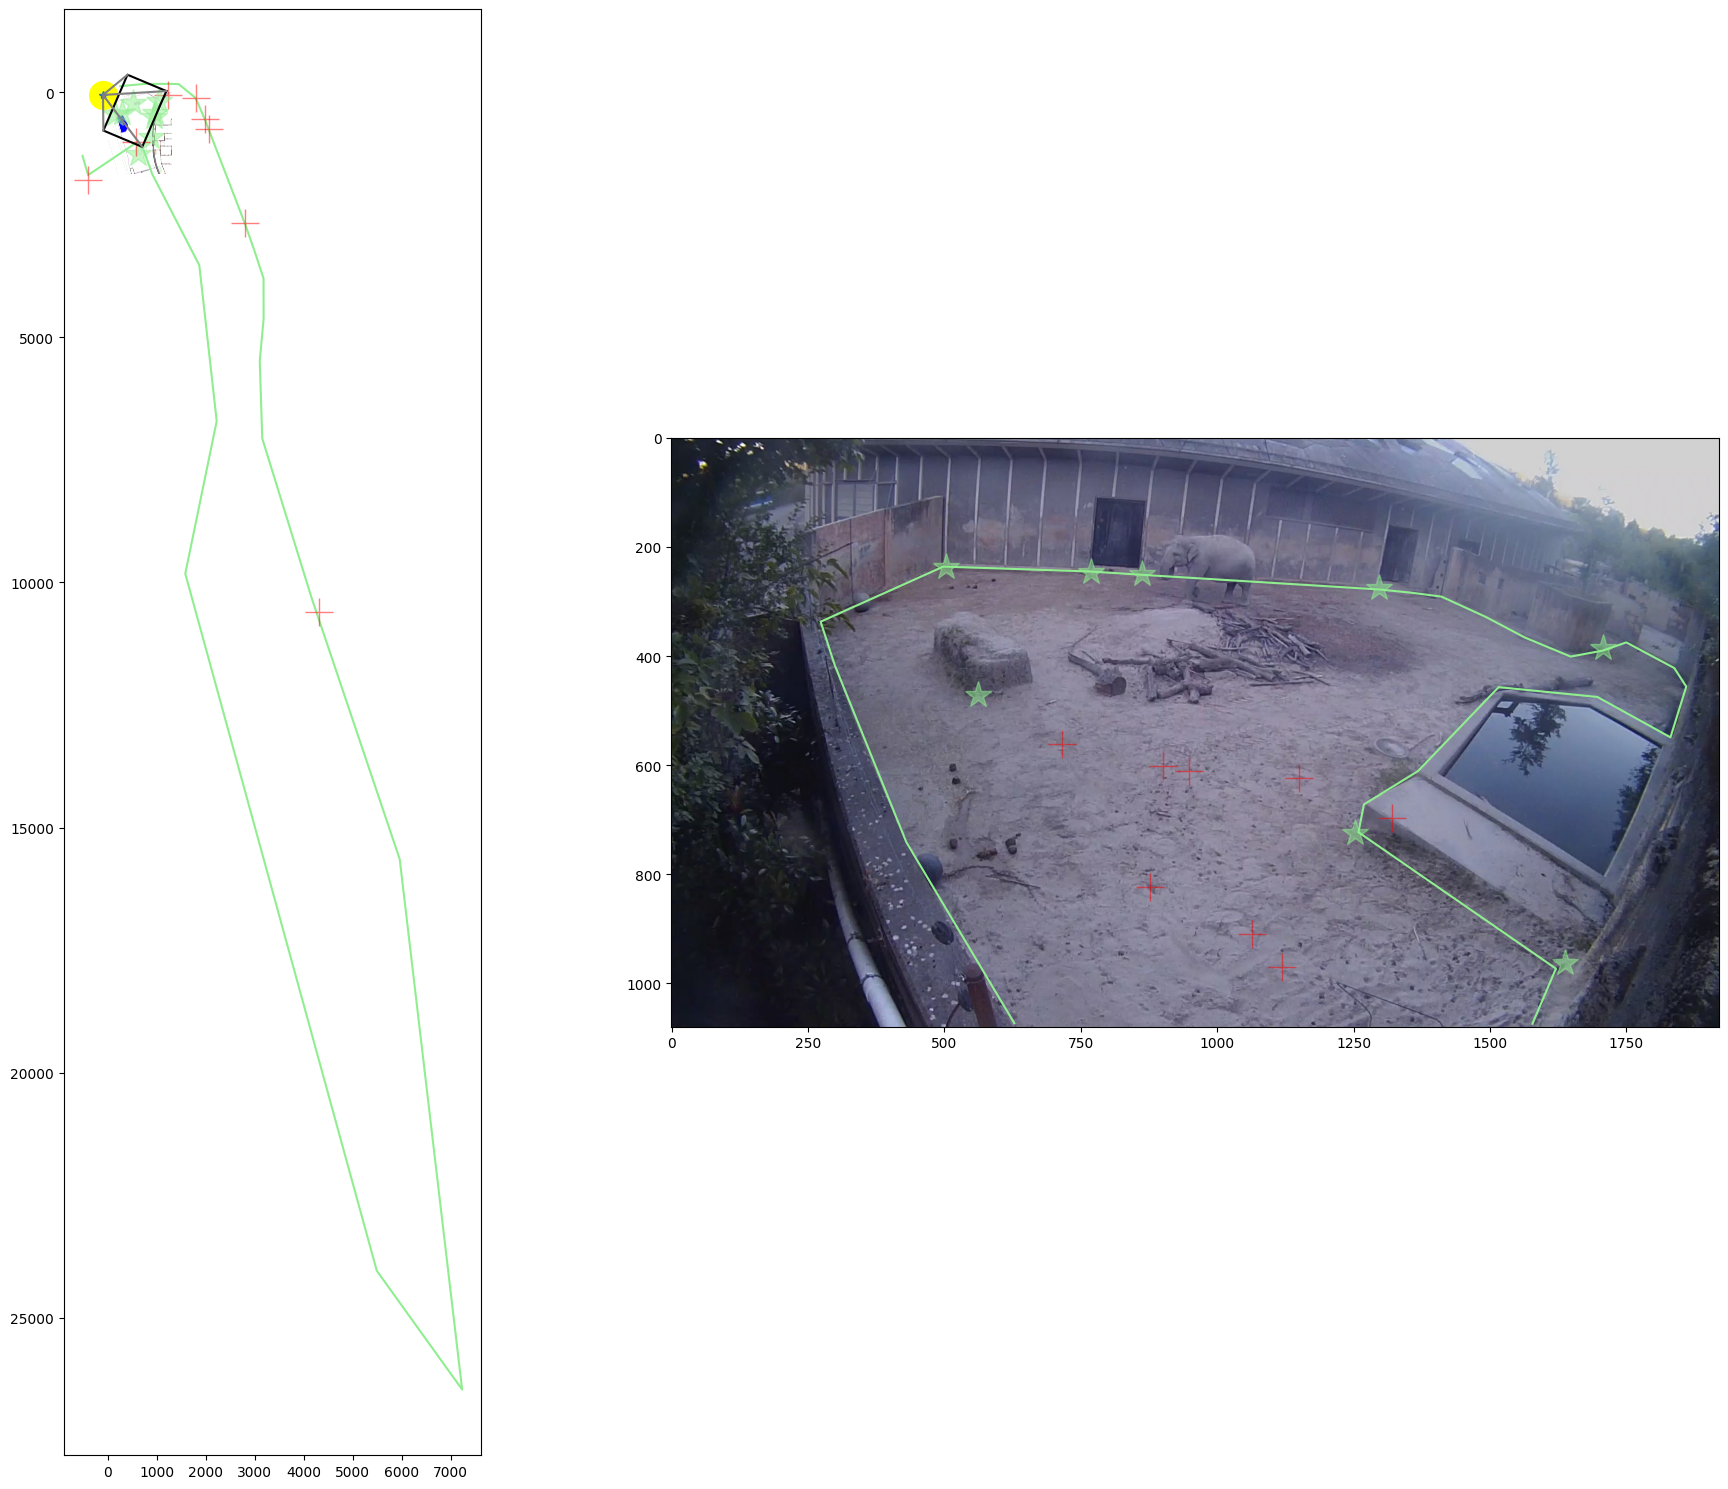

In [365]:
def test_camera(camera_in_world: KRt):
    H_camera_from_world2_exp = make_H_camera_from_world2(camera_in_world)
    if np.all(camera_in_world.dist_coef==0.) :
        print("No distortion")
    else:
        test_distortion_model(camera_in_world.dist_coef, camera_in_world.K[0:2,2], width,height)
    print(f"Camera height: {camera_in_world.t_in_world[2]}")
    axs = plot_projections(
        H_camera_from_world2_exp, camera_in_world.dist_coef, camera_in_world.K[0:2, 2]
    )

    camera_center_in_world = camera_in_world.get_center_in_world()
    # world2_points_exp = evaluator.compute_world_points(model)[:, 0:2]
    # submap_points_exp = hmult(T_submap_from_world2, world2_points_exp)
    # camera_points_exp = model.project_points(world_points)

    # fig, axs = plt.subplots(1, 2, figsize=(20, 15))
    # axs[0].imshow(im_submap)
    # axs[1].imshow(im_camera)
    # for i in range(camera_constraints.camera_points.shape[0]):
    #     cp = camera_constraints.camera_points[i]
    #     wp = submap_points[i]
    #     cp2 = camera_points_exp[i]
    #     wp2 = submap_points_exp[i]
    #     c = f"C{i}"
    #     axs[0].plot(wp[0], wp[1], "*", markersize=20, color=c)
    #     axs[0].plot(wp2[0], wp2[1], "+", markersize=20, color=c)
    #     axs[1].plot(cp[0], cp[1], "*", markersize=20, color=c)
    #     axs[1].plot(cp2[0], cp2[1], "+", markersize=20, color=c)
    axs[0].plot(
        camera_center_in_world[0],
        camera_center_in_world[1],
        "o",
        markersize=20,
        color="yellow",
    )
    plot_camera(axs[0], camera_in_world, scale=3, T_image_from_world=T_submap_from_world2)



def force_orthonormal_rotation(R2):
    R2 = h_model.R
    r1 = R2[:, 0]
    r2 = R2[:, 1]
    r3 = np.cross(r1, r2)
    R0 = np.stack([r1, r2, r3])
    W, U, Vt = cv2.SVDecomp(R0)
    Rfix = U @ Vt
    return Rfix


def camera_from_rtmodel(rtmodel: RtModel):
    dist_coef = rtmodel.dist_coef
    K = rtmodel.K
    R = force_orthonormal_rotation(rtmodel.R)
    t = rtmodel.t
    undistort_poly = fit_undistort_poly(dist_coef, K[0:2, 2], width, height) 
    return KRt(
        width=width,
        height=height,
        dist_coef=dist_coef,
        undistort_poly=undistort_poly,
        K=K,
        R_world_from_camera=R.T,
        t_in_world=-R.T @ t,
    )
    # return KRt(width=width,height=height,r_distortion=1,K=K,R_world_from_camera=R,t_in_world=t)


# H_exp = make_H(h_model.K, Rfix, h_model.t)
# errors = np.mean(np.linalg.norm(camera_constraints.camera_points -  hmult(H_exp, camera_constraints.world_points[:,0:2]), axis=1))
# print("Mean H direct error (camera units): ", errors)
# plot_projections(H_exp)
camera_from_decomposition = camera_from_rtmodel(h_model)
test_camera(camera_from_decomposition)
# plot_projections(make_H_camera_from_world2(camera_from_decomposition))

Cost at start=1175.8228467219378, delta=-1111.0975258798123
Cost at start=64.72532084212551, delta=-3.320903169399955
model=dist_coef=[-5.56107349e-33 -1.00702303e-26 -2.57803691e-20]
K=
[[167.28501587   0.         937.82791249]
 [  0.         138.78049796 970.45564233]
 [  0.           0.           1.        ]]
R_world_from_camera=
[[-0.35611556 -0.92594849  0.12570245]
 [-0.93402623  0.34870968 -0.07743743]
 [ 0.02786941 -0.14498606 -0.98904112]]
t_in_world=[-97.15858404  53.17602052   1.08693512]
camera_center_in_world=array([-97.15858404,  53.17602052,   1.08693512])
Poly coef: [ 1.00144206 -0.02115524 -0.07531738  0.07796082  0.20957648 -0.12402332
 -0.20733056]
Errors: mean=320725.946765939, max=29213120.23478561
Camera height: 1.0869351239570368
Error (submap units): mean=51.30868461490054, max=117.41785540803313, sum=410.46947691920434
Error (world units): mean=1.447887975412017, max=3.3132918311219823, sum=11.583103803296137
Error (camera units): mean=22.060966639165287, max=3

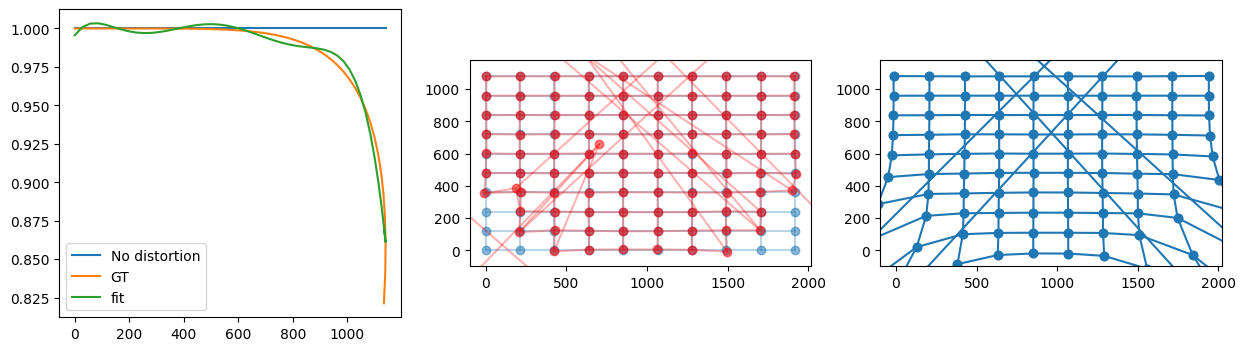

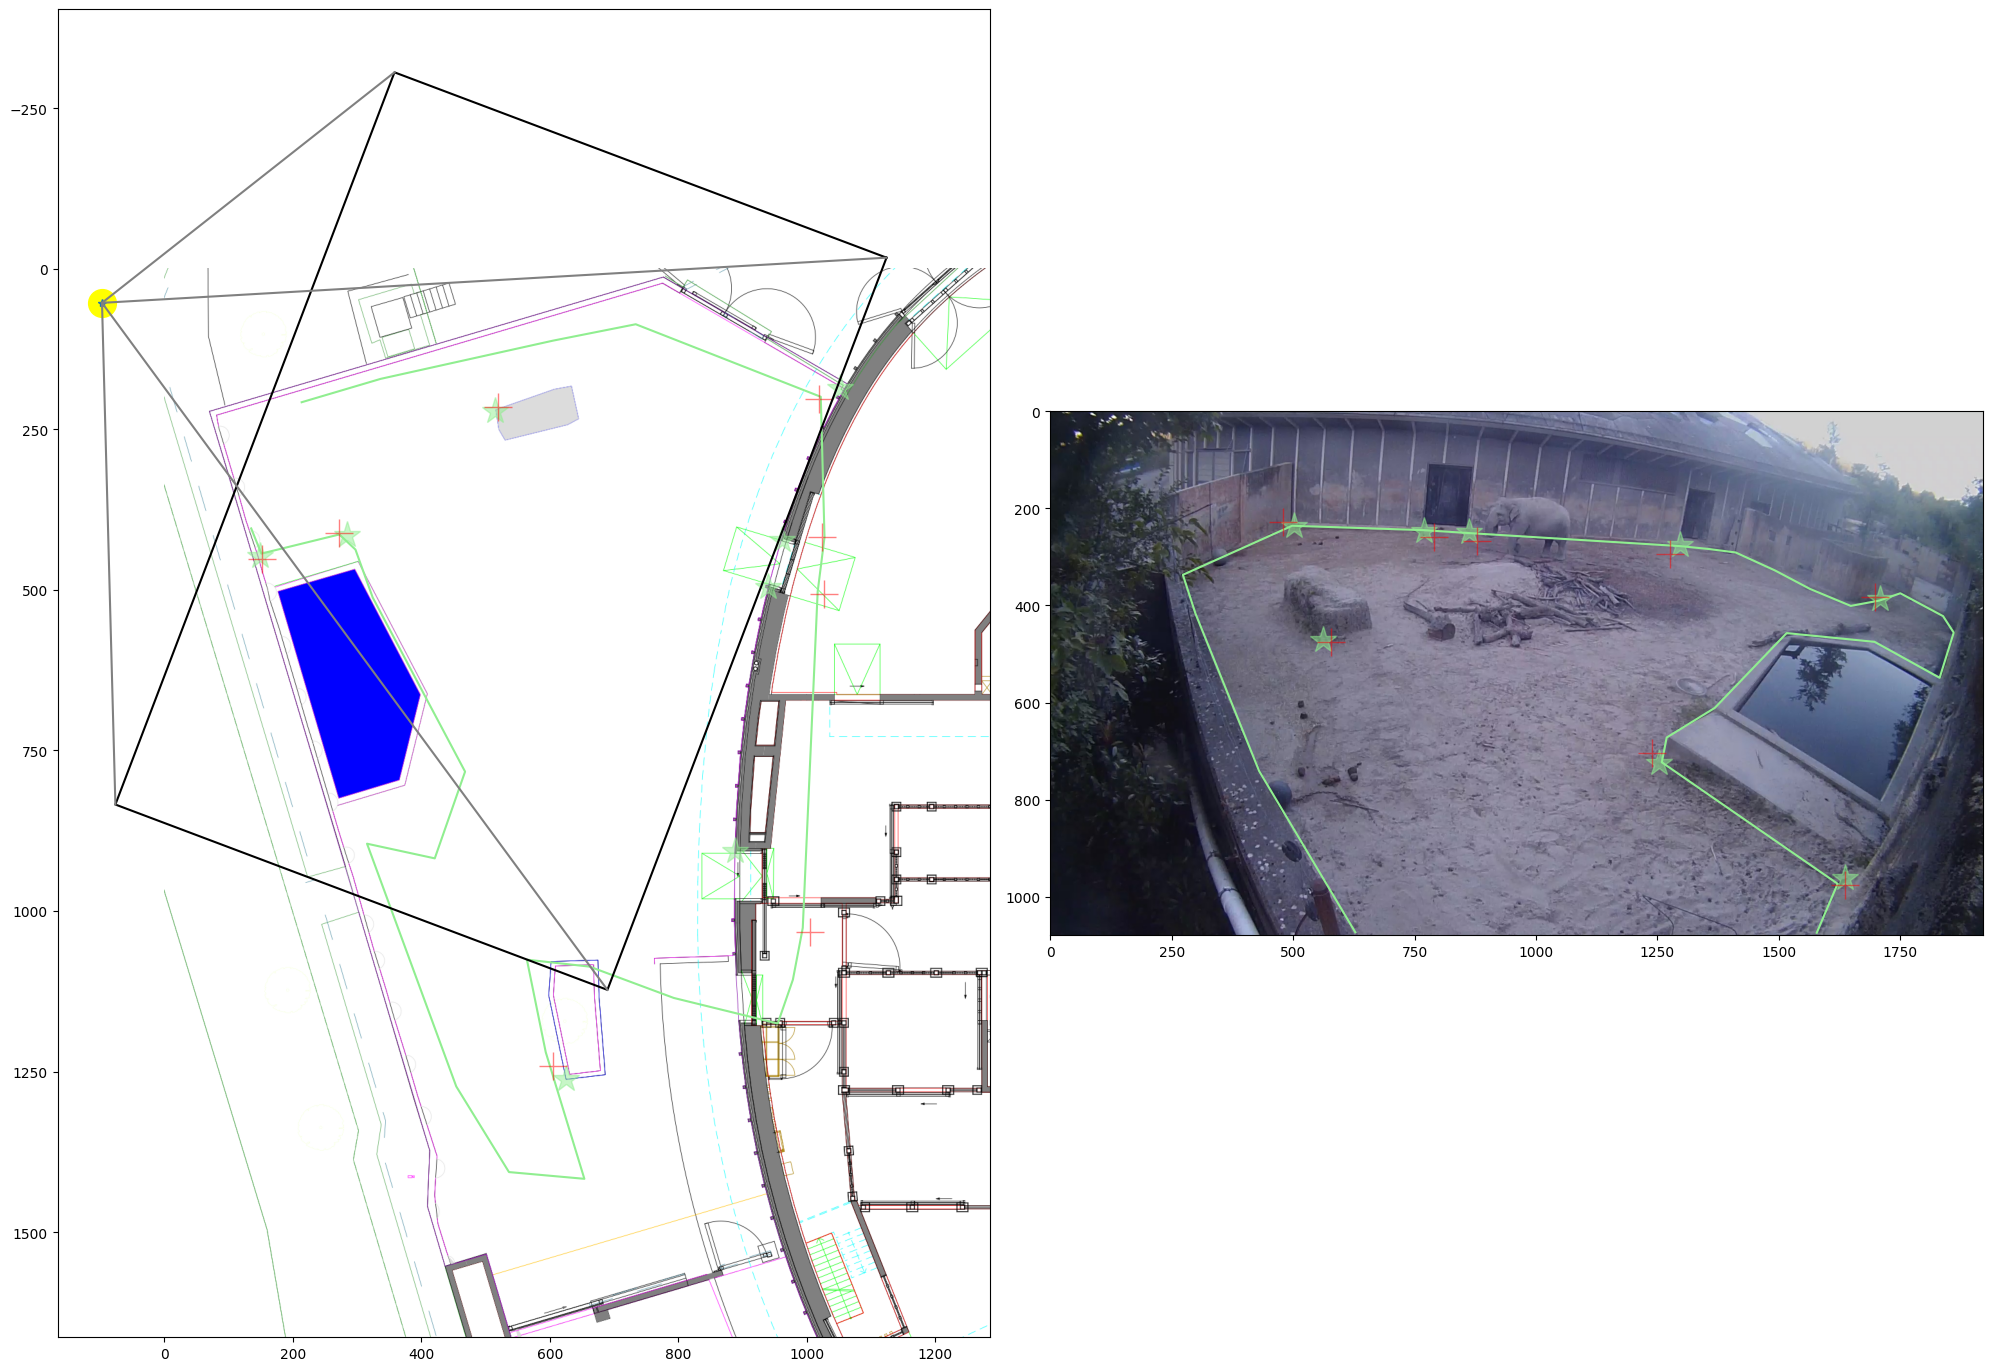

In [382]:
class ProjectionEvaluator(IModelEvaluator[KRt]):
    def __init__(
        self, camera_points: np.ndarray, world_points: np.ndarray, model0: KRt
    ):
        super().__init__()
        self.world_points = world_points
        self.camera_points = camera_points
        self.model0 = model0
        self.fix_dist = True

    def model2params(self, model: KRt) -> np.ndarray:
        rp, _ = cv2.Rodrigues(model.R_world_from_camera)
        rx, ry, rz = rp.reshape((3,))
        tx, ty, tz = model.t_in_world.reshape((3,))

        fx = model.K[0, 0]
        alpha = model.K[1, 1] / model.K[0, 0]
        cx = model.K[0, 2]
        cy = model.K[1, 2]

        k1,k2,k3 = model.dist_coef*1e6
        params_list = [fx, alpha, cx, cy, rx, ry, rz, tx, ty, tz,k1,k2,k3]
        return np.array(params_list)

    def params2model(self, params: np.ndarray) -> KRt:
        fx, alpha, cx, cy, rx, ry, rz, tx, ty, tz,k1,k2,k3 = params

        dist_coef = np.array([k1,k2,k3])/1e6
        R, _ = cv2.Rodrigues(np.array([rx, ry, rz]))
        t = np.array([tx, ty, tz])

        K = np.array([[fx, 0, cx], [0, fx * alpha, cy], [0, 0, 1]])

        # Fixed parameters
        # K[0,0] = self.model0.K[0,0]
        # K[1,1] = K[0,0]
        if self.fix_dist:
            dist_coef = model0.dist_coef
        # K[2, 2] = 3

        model = KRt(
            width=self.model0.width,
            height=self.model0.height,
            dist_coef=dist_coef,
            undistort_poly=self.model0.undistort_poly,
            K=K,
            R_world_from_camera=R,
            t_in_world=t,
        )
        return model

    def getParamBounds(self) -> scipy.optimize.Bounds:
        params0 = self.model2params(self.model0)
        lb = np.full_like(params0, -np.inf)
        lb[0] = 0.1
        lb[1] = 0.1
        return scipy.optimize.Bounds(lb=lb)

    def compute_world_points(self, model: KRt, debug=False) -> np.ndarray:
        center = model.get_center_in_world()

        world_points_d1 = model.unproject_points(self.camera_points)
        x_dir = world_points_d1 - center

        depth = -center[2] / x_dir[:, 2]
        world_points_exp = center + x_dir * depth[:, None]

        if debug:
            print(
                f"{self.camera_points=}\n{world_points_d1=}\n{x_dir=}\n{depth=}\n{world_points_exp=}"
            )
        return world_points_exp

    def compute_errors(self, model: KRt, debug=False) -> np.ndarray:
        # world_points_exp = self.compute_world_points(model, debug)
        # errors_world = self.world_points - world_points_exp

        camera_points_exp = model.project_points(self.world_points)
        errors_camera = self.camera_points - camera_points_exp

        # return np.concatenate([errors_world, errors_camera], axis=1)
        return errors_camera

    def evaluateModel(self, model: KRt) -> float:
        return np.linalg.norm(self.compute_errors(model)) 


# model0 = KRt(width=width, height=height, r_distortion=1, K=h_model.K, R_world_from_camera=h_model.R.T, t_in_world=-h_model.R.T@h_model.t)
model0 = camera_from_decomposition
evaluator = ProjectionEvaluator(
    camera_points=camera_constraints.camera_points,
    world_points=camera_constraints.world_points,
    model0=model0,
)
# display(m0)
errors0 = evaluator.compute_errors(model0)
# display(errors0)

cost0 = evaluator.evaluateModel(model0)
model_nodist = optimizeModel(evaluator, model0, debug=False)
cost_nodist = evaluator.evaluateModel(model_nodist)
print(f"Cost at start={cost0}, delta={cost_nodist-cost0}")

evaluator.fix_dist = False
model = optimizeModel(evaluator, model_nodist, debug=False)
cost = evaluator.evaluateModel(model)
print(f"Cost at start={cost_nodist}, delta={cost-cost_nodist}")

# model=model0
# display("")
# print(f"Final errors: {evaluator.compute_errors(model,debug=False)}")
print(f"{model=}")

camera_center_in_world = model.get_center_in_world()
print(f"{camera_center_in_world=}")

# Display points
test_camera(model)
fig.tight_layout()

In [18]:
import json
from pathlib import Path

import scipy.spatial

config_file = Path("../data/config.json")
try:
    with config_file.open() as f:
        config = json.load(f)
except:
    config = {}

# Save map
config["map"] = {}
config["map"]["image"] = str(map_file)
config["map"]["T_map_from_world2"] = T_map_from_world2.tolist()


# Save cameras
if "cameras" not in config:
    config["cameras"] = {}
config["cameras"][camera_name] = {}
camera_config = config["cameras"][camera_name]

camera_config["sample_image"] = str(image_filename)
camera_config["intrinsics"] = {
    "width": width,
    "height": height,
    "K": model.K.tolist(),
    "distortion": [model.distortion_k1],
}
R_world_from_camera: scipy.spatial.transform.Rotation = (
    scipy.spatial.transform.Rotation.from_matrix(model.R_world_from_camera)
)
camera_config["T_world_from_camera"] = {
    "R": R_world_from_camera.as_quat(canonical=True, scalar_first=False).tolist(),
    "t_in_world": model.t_in_world.tolist(),
}
camera_config["H_world2_from_camera"] = np.linalg.inv(
    make_H_camera_from_world2(model)
).tolist()

config_json = json.dumps(config, indent=2)
print(config_json)

with config_file.open("w") as f:
    f.write(config_json)

{
  "map": {
    "image": "kkep_floorplan.png",
    "T_map_from_world2": [
      [
        35.4334161426658,
        0.0,
        4278.915070787953
      ],
      [
        0.0,
        -35.442265183206494,
        3656.779741115093
      ],
      [
        0.0,
        0.0,
        1.0
      ]
    ]
  },
  "models": {
    "segmentation2": "../models/camera0/segmentation/torch.pt",
    "segmentation": "../models/maskrcnn_trained.ptc"
  },
  "cameras": {
    "Kamera 01": {
      "sample_image": "cameras/Kamera 01/ELP-Kamera-01-20240907-185521-1725728121288-7_00000000_img.jpg",
      "intrinsics": {
        "width": 1920,
        "height": 1080,
        "K": [
          [
            163.1582442729504,
            0.0,
            951.0046259704997
          ],
          [
            0.0,
            70.5979673949018,
            513.3088024547918
          ],
          [
            0.0,
            0.0,
            1.0
          ]
        ],
        "distortion": [
          0
       